In [9]:
#import sys
#sys.path.append('/Users/ezragoliath/Desktop/Masters thesis/code/modules')
#sys.path.append('/home/bmll/local')

In [1]:
import bmll2 as b2
b2.get_file('modules/auxiliary_functions.py')

'auxiliary_functions.py'

In [2]:
import auxiliary_functions as af
#import data_handling_functions as dh

import random
import math
import pandas as pd
import numpy as np
from pandas import StringDtype
from pathlib import Path
import shutil

# we need to add the functions because having them in the .py files only mkaes it accessible in those files so we either import it
# again or we need to do something like dh.pd.DataFrame. The dh. part means that use the module dh and from that module use pd.DataFrame

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LogFormatterSciNotation

In [3]:
%%time
files = b2.list_files(path = 'top_100(Volume)')
files
for f in files:
    b2.get_file(f'top_100(Volume)/{f}')

CPU times: user 1min 1s, sys: 1min 13s, total: 2min 15s
Wall time: 1min 59s


In [4]:
%%time
def load_stock(csv):
    df = pd.read_csv(csv, parse_dates = ['DateTime', 'Date'])
    df = df.rename(columns = {'Ticker': 'RIC'})
    return df
    
stocks = {
    'GRT': load_stock('GRT.csv'),
    'OMU': load_stock('OMU.csv'),
    'RMH': load_stock('RMH.csv'),
    'MTN': load_stock('MTN.csv'),
    'ABG': load_stock('ABG.csv'),
    'GFI': load_stock('GFI.csv'),
    'SHP': load_stock('SHP.csv'),
    'AGL': load_stock('AGL.csv'),
    'MNP': load_stock('MNP.csv'),
    'RNI': load_stock('RNI.csv'),
}

CPU times: user 52 s, sys: 4.54 s, total: 56.5 s
Wall time: 56.6 s


In [6]:
def process_stock(stock_data, N = 4, participation_method = 'homogeneous', timing_method = 'immediate', impact_method = 'all'):
    features_list = []

    for date, day_D in stock_data.groupby('Date', sort = True):
        #print(date)
        
        trades = day_D
        
        if trades.empty:
            continue

        f = af.trader_participation(N = N, method = participation_method, alpha = 2, f_min = 1,f_max = trades.shape[0], seed = 1)

        c = af.cumulative_probs(f)
        output = af.orders(N = N, trades = trades, cumulative_probs = c)

        for n in range(N):
            trader_n_trades = trades.iloc[output[n]]

            if trader_n_trades.empty:
                continue

            trader_n_metaorders = af.metaorders(trader_n_trades)

            if len(trader_n_metaorders) == 0:
                continue

            trader_n_features = af.impact_df(trader_n_metaorders, timing_method = timing_method, impact_method = impact_method)

            features_list.append(trader_n_features)

    if features_list:
        return pd.concat(features_list, ignore_index = True)
    else:
        return pd.DataFrame()

In [9]:
stocks['GRT'].head()

,MIC,RIC,ListingId,Date,DateTime,ExchangeSequenceNo,Daily Volume,Daily Volatility,Trade Sign,Price,Volume,Mid-price before,Mid-price after(immediate),Mid-price after(delayed)
0,XJSE,GRT,418405583,2023-01-10,2023-01-10 09:02:32.811833,128673,2714257.0,0.021111,1,1480.0,2144.0,1477.5,1479.5,1477.5
1,XJSE,GRT,418405583,2023-01-10,2023-01-10 09:02:32.812055,128677,2714257.0,0.021111,1,1480.0,245.0,1477.5,1480.0,1477.5
2,XJSE,GRT,418405583,2023-01-10,2023-01-10 09:02:32.812078,128678,2714257.0,0.021111,1,1480.0,2312.0,1477.5,1480.0,1477.5
3,XJSE,GRT,418405583,2023-01-10,2023-01-10 09:02:32.812115,128679,2714257.0,0.021111,1,1480.0,2865.0,1477.5,1480.0,1480.0
4,XJSE,GRT,418405583,2023-01-10,2023-01-10 09:02:32.984925,128759,2714257.0,0.021111,1,1479.0,10762.0,1480.0,1479.5,1478.5


In [ ]:
%%time
all_features = []

for ric, data in stocks.items():
    print(f'Processing {ric}')
    stock_features = process_stock(data, N = 4, participation_method = 'homogenous', timing_method = 'immediate', impact_method = 'all')

    if not stock_features.empty:
        all_features.append(stock_features)

homo_4_immediate = pd.concat(all_features, ignore_index = True)
homo_4_immediate.to_csv('homo_4_immediate.csv', index = False)
b2.put_file('homo_4_immediate.csv', 'test_data')

# takes about 4 hours to run

In [8]:
homo_4_immediate.head()

,RIC,Date,Start time,End time,daily volume,intraday volatility,number child orders,volume traded,trade sign,impact(shortfall),impact(ave per trade),impact(simple)
0,GRT,2023-01-03 00:00:00,2023-01-03 09:05:10.842369,2023-01-03 09:05:23.313963,6862853.0,0.034551,2,5709.0,1,0.001739,0.000878,0.001731
1,GRT,2023-01-03 00:00:00,2023-01-03 09:13:38.621423,2023-01-03 09:23:19.168528,6862853.0,0.034551,4,11789.0,-1,0.00116,0.000164,-0.00069
2,GRT,2023-01-03 00:00:00,2023-01-03 09:36:01.673338,2023-01-03 10:15:32.159365,6862853.0,0.034551,10,26394.0,-1,-0.000634,0.00005,0.001382
3,GRT,2023-01-03 00:00:00,2023-01-03 10:16:22.407365,2023-01-03 10:16:22.490396,6862853.0,0.034551,2,6563.0,-1,0.001378,-0.0,0.000689
4,GRT,2023-01-03 00:00:00,2023-01-03 10:16:22.541073,2023-01-03 10:16:23.651954,6862853.0,0.034551,2,15862.0,-1,0.001723,0.000726,0.001033


In [ ]:
%%time
stock_data = stocks['GRT'][(stocks['GRT']['Date'] >= '2023-01-01 00:00:00') & 
                   (stocks['GRT']['Date'] <= '2023-01-31 00:00:00')]

N = 4
features_list = []
for date, day_D in stock_data.groupby('Date', sort = True):

    trades = day_D
    
    f = af.trader_participation(N = N, method = 'homogenous', alpha = 2, f_min = 1, f_max = trades.shape[0] , seed = 1)
    c = af.cumulative_probs(f)
    
    if trades.empty:
        continue

    output = af.orders(N = N, trades = trades, cumulative_probs = c)
    for n in range(N):
        
        trader_n_trades = trades.iloc[output[n], ]
       
        if trader_n_trades.empty:
            continue

        trader_n_metaorders = af.metaorders(trader_n_trades)
        
        if len(trader_n_metaorders) == 0:
            continue

        trader_n_features = af.impact_df(trader_n_metaorders, timing_method = 'immediate', impact_method = 'all')
        features_list.append(trader_n_features)

    print(date)

AGL_features = pd.concat(features_list, ignore_index = True)

In [18]:
AGL_features.head()
AGL_features['Date']       = pd.to_datetime(AGL_features['Date'], errors = 'coerce')
AGL_features['Start time'] = pd.to_datetime(AGL_features['Start time'], errors = 'coerce')
AGL_features['End time']   = pd.to_datetime(AGL_features['End time'], errors = 'coerce')

In [19]:
AGL_features.head()

,RIC,Date,Start time,End time,daily volume,intraday volatility,number child orders,volume traded,trade sign,impact(shortfall),impact(ave per trade),impact(simple)
0,AGL,2023-01-03,2023-01-03 09:05:07.210790,2023-01-03 09:15:38.527148,453236.0,0.018674,4,418.0,1,0.00217,0.000258,0.006093
1,AGL,2023-01-03,2023-01-03 09:18:48.526544,2023-01-03 09:23:20.103792,453236.0,0.018674,6,324.0,-1,0.002989,0.000047,0.002456
2,AGL,2023-01-03,2023-01-03 09:24:17.372554,2023-01-03 09:24:42.540623,453236.0,0.018674,3,291.0,1,0.000776,0.000493,0.000722
3,AGL,2023-01-03,2023-01-03 09:25:00.119142,2023-01-03 09:28:31.092101,453236.0,0.018674,5,425.0,-1,0.002236,0.000047,0.002948
4,AGL,2023-01-03,2023-01-03 09:35:12.840937,2023-01-03 09:35:23.140791,453236.0,0.018674,4,231.0,1,0.000723,0.000178,0.000686


In [20]:
n_intervals = 40
bins        = np.logspace(-6, 0, n_intervals, base = 10, endpoint = True)

x_AGL = AGL_features['volume traded'] / AGL_features['daily volume']
y_AGL = AGL_features['impact(simple)'] / AGL_features['intraday volatility']

#bins_AGL           = np.logspace(np.log10(x_AGL.min()), np.log10(x_AGL.max()), n_intervals, base = 10, endpoint = True)
x_bins_AGL         = pd.cut(x_AGL, bins = bins) 

y_bins_vals_AGL    = y_AGL.groupby(x_bins_AGL, observed = False).mean()
x_bins_centers_AGL = [interval.mid for interval in y_bins_vals_AGL.index.categories]

alpha    = 0.5
sqrt_law = alpha * np.sqrt(x_bins_centers_AGL)

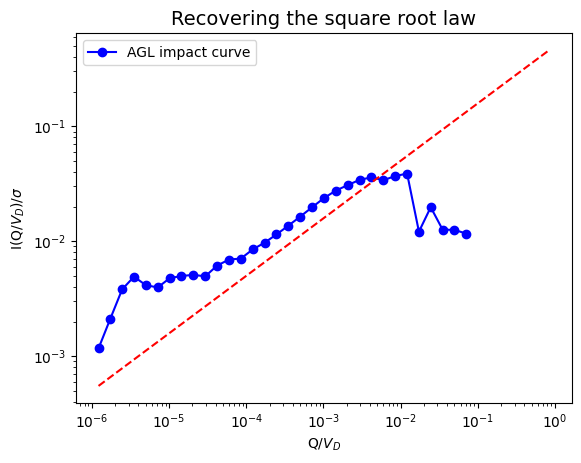

In [21]:
fig, ax = plt.subplots()

ax.set_title('Recovering the square root law', fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(x_bins_centers_AGL, y_bins_vals_AGL, marker = 'o', color = 'blue', label = 'AGL impact curve')
#ax.plot(x_bins_centers_MTN, y_bins_vals_MTN, marker = 'o', color = 'yellow', label = 'MTN impact curve')
#ax.plot(x_bins_centers_GRT, y_bins_vals_GRT, marker = 'o', color = 'purple', label = 'GRT impact curve')
#ax.plot(x_bins_centers_ANG, y_bins_vals_ANG, marker = 'o', color = 'green', label = 'ANG impact curve')
#ax.plot(x_bins_centers_SAB, y_bins_vals_SAB, marker = 'o', color = 'orange', label = 'SAB impact curve')
ax.plot(x_bins_centers_AGL, sqrt_law, linestyle = '--', color = 'red')

ax.set_xlabel(r'Q/$V_{D}$')
ax.set_ylabel(r'I(Q/$V_{D}$)/$\sigma$')

# force scientific notation 10^n ticks
ax.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase = False))
ax.yaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase = False))

plt.legend()
plt.show()

In [13]:
Jan_May_compiled = pd.DataFrame(columns = ['RIC', 'Date', 'Start time', 'End time', 'daily volume', 'intraday volatility', 
                                           'number child orders', 'volume traded', 'trade sign', 'impact(shortfall)',
                                           'impact(ave per trade)', 'impact(simple)'])

In [15]:
jan_may_path   = Path('/Users/ezragoliath/Desktop/Masters thesis/test data/January_May_processed')
jan_may_stocks = jan_may_path.iterdir()

N = 4

for stock in jan_may_path.iterdir():
    if not stock.is_file():
        continue

    #print(f'Processing {stock.name}...')

    # read the already-processed file into a DataFrame
    stock_data = pd.read_csv(stock, parse_dates = ['DateTime', 'Date'])  # or read_csv() depending on format

    # loop through each day in the data
    for date, day_D in stock_data.groupby('Date', sort = False):
        
        f = af.trader_participation(N = N, method = 'homogenous', alpha = 2, f_min = 1, f_max = 1000, seed = 1)
        c = af.cumulative_probs(f)

        trades = day_D.loc[day_D['Price'] != 0]
        if trades.empty:
            continue

        output = af.orders(N = N, trades = trades, cumulative_probs = c)
        for n in range(N):
            
            trader_n_trades = trades.iloc[output[n], ]
           
            if trader_n_trades.empty:
                continue

            trader_n_metaorders = af.metaorders(trader_n_trades)
            
            if len(trader_n_metaorders) == 0:
                continue

            trader_n_features = af.impact_df(trader_n_metaorders, timing_method = 'immediate', impact_method = 'all')
            
            if not trader_n_features.empty and not trader_n_features.isna().all().all():
                Jan_May_compiled = pd.concat([Jan_May_compiled, trader_n_features], ignore_index = True)

    print('Done with', stock.name)

Jan_May_compiled.to_csv('/Users/ezragoliath/Desktop/Masters thesis/metaorder test dfs/Jan_May_compiled_4_homo_immediate.csv', index = False)

Done with VODJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with CFRJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with SBKJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with BVTJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with BILJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with OMLJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with MNDJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with BATJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with REMJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with MTNJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with AGLJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with FSRJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with WHLJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with TBSJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with MNPJ.J02-Jan-2015_TO_27-May-2015_cleaned_processed.csv
Done with SOLJ.J02-Jan-20

In [17]:
May_Dec_compiled = pd.DataFrame(columns = ['RIC', 'Date', 'Start time', 'End time', 'daily volume', 'intraday volatility',
                                           'number child orders', 'volume traded', 'trade sign', 'impact(shortfall)', 
                                           'impact(ave per trade)', 'impact(simple)'])

In [ ]:
may_dec_path   = Path('/Users/ezragoliath/Desktop/Masters thesis/test data//May_December_processed')
may_dec_stocks = may_dec_path.iterdir()

N = 4

for stock in may_dec_path.iterdir():
    if not stock.is_file():
        continue

    #print(f'Processing {stock.name}...')

    # read the already-processed file into a DataFrame
    stock_data = pd.read_csv(stock, parse_dates = ['DateTime', 'Date'])  # or read_csv() depending on format

    # loop through each day in the data
    for date, day_D in stock_data.groupby('Date', sort = False):
        
        f = af.trader_participation(N = N, method = 'homogenous', alpha = 2, f_min = 1, f_max = 1000, seed = 1)
        c = af.cumulative_probs(f)

        trades = day_D.loc[day_D['Price'] != 0]
        if trades.empty:
            continue

        output = af.orders(N = N, trades = trades, cumulative_probs = c)
        for n in range(N):
            
            trader_n_trades = trades.iloc[output[n], ]
           
            if trader_n_trades.empty:
                continue

            trader_n_metaorders = af.metaorders(trader_n_trades)
            
            if len(trader_n_metaorders) == 0:
                continue

            trader_n_features = af.impact_df(trader_n_metaorders, timing_method = 'immediate', impact_method = 'all')
            
            if not trader_n_features.empty and not trader_n_features.isna().all().all():
                May_DEC_compiled = pd.concat([May_DEC_compiled, trader_n_features], ignore_index = True)

    print('Done with', stock.name)

May_Dec_compiled.to_csv('/Users/ezragoliath/Desktop/Masters thesis/metaorder test dfs/May_Dec_compiled_4_homo_immediate.csv', index = False)